---
**License**

 NC_ccl_xcor_auto_cmblensing

 Fri Mar 01 12:00:00 2024\
 Copyright  2024\
 Luigi Lucas de Carvalho Silva <luigi.lcsilva@gmail.com>

---
---

 NC_ccl_xcor_auto_cmblensing\
 Copyright (C) 2024 Luigi Lucas de Carvalho Silva <luigi.lcsilva@gmail.com>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Startups and Packages

First of all, let us import some useful packages.

In [1]:
######## NUM COSMO ########
try:
    import gi

    gi.require_version("NumCosmo", "1.0")
    gi.require_version("NumCosmoMath", "1.0")
except:
    pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

######## CCL ########
import pyccl as pyccl

######## GENERAL ########
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

######## COMPARISSON ########
sys.path.append('/home/luigi/cosmology/NumCosmo/numcosmo_py/ccl/')

from nc_ccl import create_nc_obj
from nc_ccl import CCLParams

ccl_params_class = CCLParams()
ccl_cosmo_set_high_prec = ccl_params_class.set_high_prec_params

#create_nc_obj: Create a NumCosmo object from a CCL cosmology.
#ccl_cosmo_set_high_prec: Set CCL cosmology to high precision.

Now, let us get the libraries versions.

In [2]:
### GETTING NUMCOSMO VERSION
#dir(Ncm) # Show the library functions.

ncmpath = Ncm.__path__[0]
ncmpath = ncmpath.replace("/NumCosmoMath-1.0.typelib","")
buildfile = open(ncmpath+"/build_cfg.h", "r").readlines()

for line in buildfile:
    if "NUMCOSMO_VERSION" in line:
        ncversion=line
        for ch in ['#define','NUMCOSMO_VERSION','"','\n','  ']:
            if ch in ncversion:
                ncversion = ncversion.replace(ch,'')
print('NumCosmo Version: '+ncversion)
                
### GETTING CCL VERSION
print("CCL Version: "+str(pyccl.__version__))

NumCosmo Version: 0.22.0
CCL Version: 3.0.3.dev12+gaae09e9d.d20240717


Now, let us initialize the NumCosmo library.

In [3]:
Ncm.cfg_init ()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


## Cosmological parameters

In [4]:
# Fixed parameters.
Neff_massless_neutrinos = 3.0       # Effective number of massless neutrinos present. For the massive case, the Neff is
                                    # defined with the other parameters in the cosmology array.   
T_CMB = 2.726                       # The CMB temperature today. 

######### COSMOLOGIES ##########
#Reference: https://arxiv.org/pdf/1812.05995.pdf, Table 3 and Table 4.
#Order of parameters: Omega_c, Omega_b, Omega_v, h, sigma8, n_s, w0, wa, Neff, m_nu
CCL_cosmologies = {}
### MASSLESS NEUTRINOS ####
CCL_cosmologies["CCL1"] = [0.25, 0.05, 0.7, 0.7, 0.8, 0.96, -1.0, 0.0, Neff_massless_neutrinos, 0]  #flat ΛCDM
CCL_cosmologies["CCL2"] = [0.25, 0.05, 0.7, 0.7, 0.8, 0.96, -0.9, 0.0, Neff_massless_neutrinos, 0]  #wCDM
CCL_cosmologies["CCL3"] = [0.25, 0.05, 0.7, 0.7, 0.8, 0.96, -0.9, 0.1, Neff_massless_neutrinos, 0 ]  #wCDM
#CCL_cosmologies["CCL4"] = [0.25, 0.05, 0.65, 0.7, 0.8, 0.96, -0.9, 0.1, Neff_massless_neutrinos, 0] #open wCDM    # Bad results for k different from 0.
#CCL_cosmologies["CCL5"] = [0.25, 0.05, 0.75, 0.7, 0.8, 0.96, -0.9, 0.1, Neff_massless_neutrinos, 0] #closed wCDM  # Bad results for k different from 0.
#CCL_cosmologies["CCL6"] = [0.3, 0.0, 0.7, 0.7, 0.8, 0.96, -1.0, 0.0, Neff_massless_neutrinos, 0]    #flat ΛCDM    # Kernel dying for this cosmology
CCL_cosmologies["WMAP7"] = [0.2265, 0.0455, 0.728, 0.704, 0.810, 0.967, -1.0, 0.0, Neff_massless_neutrinos, 0] #flat ΛCDM
CCL_cosmologies["Planck2013"] = [0.269, 0.0490, 0.682, 0.671, 0.834, 0.962, -1.0, 0.0, Neff_massless_neutrinos, 0] #flat ΛCDM
### MASSIVE NEUTRINOS ####
# Obs.: The create_nc_obj from nc_ccl.py is not updated for the new version of CCL. So, we cannot include massive neutrinos right now.
#CCL_cosmologies["CCL7"] = [0.25, 0.05, 0.7, 0.7, 0.8, 0.96, -1.0, 0.0, 3.013, [0.04,0,0]]  #flat ΛCDM, mν

names = []
for key, value in CCL_cosmologies.items():
    names.append(key)

# Defining the function for the comparisson

In [5]:
#CMB Lensing not working properly.
def compare_CMBlens_CMBlens_angular_cl(Omega_c, Omega_b, Omega_v, h, sigma8, n_s, w0, wa, Neff, m_nu, z_lss, ells):
    """
    Compare the angular power spectrum of CMB lensing.
    """
    ##### GENERAL #####
    # Set Omega_K in a consistent way
    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ##### COSMOLOGIES #####
    # Defining the CCL cosmology.
    ccl_cosmo = pyccl.Cosmology(
        Omega_c=Omega_c, 
        Omega_b=Omega_b, 
        Neff=Neff,
        m_nu=m_nu,
        h=h, 
        n_s=n_s,
        Omega_k=Omega_k, 
        Omega_g=None,
        w0=w0, 
        wa=wa, 
        sigma8=sigma8,
        transfer_function='eisenstein_hu',
        T_CMB = T_CMB,
        matter_power_spectrum='linear',
    )
    # Setting CCL to high precision.
    ccl_cosmo_set_high_prec()

    # Defining the NumCosmo cosmology.
    cosmo, dist, ps_lin, ps_nln, hmfunc = create_nc_obj(ccl_cosmo)
    # More info: https://github.com/NumCosmo/NumCosmo/blob/master/numcosmo_py/ccl/nc_ccl.py

    ##### CCL POWER SPECTRUM COMPUTATION #####
    # Initialize tracers in CCL.
    trcs_ccl = dict()
    trcs_ccl['cmb1'] = pyccl.CMBLensingTracer(ccl_cosmo, z_source=z_lss)

    # Computing the angular power spectrum in CCL.
    ccl_cl_cmblens_auto1 = pyccl.angular_cl(ccl_cosmo, trcs_ccl['cmb1'], trcs_ccl['cmb1'], ells, l_limber=-1)

    # Converting to Numpy array
    ccl_cl_cmblens_auto1_np = np.array(ccl_cl_cmblens_auto1)

    ##### NUMCOSMO POWER SPECTRUM COMPUTATION #####
    ### Recombination by Seager
    recomb = Nc.RecombSeager()
    Nl_lensing = Ncm.Vector.new_array (np.zeros(lmax+1))
    #recomb.prepare (cosmo)

    # Defining the kernels in NumCosmo.
    nc_cmblens_1 = None
    ##### NcXcorLimberKernelCMBLensing
    # Parameters
    #dist: a NcDistance
    #recomb: a NcRecomb
    #Nl: a NcmVector
    nc_cmblens_1 = Nc.XcorLimberKernelCMBLensing.new (dist, recomb, Nl_lensing)

    # Pushing the objects to mset in NumCosmo.
    mset = Ncm.MSet.empty_new ()
    mset.set (cosmo)
    mset.push (nc_cmblens_1)

    # Computing the angular power spectrum in NumCosmo.
    # Parameters nc_xcor_new:
    # nc_xcor_new (NcDistance *dist, NcmPowspec *ps, NcXcorLimberMethod meth);
    # Two methods are available to compute Limber-approximated integrals: independent GSL numerical integration or 
    # vector integration using Sundials's CVode algorithm.
    xcor = Nc.Xcor.new (dist, ps_lin, Nc.XcorLimberMethod.GSL)
    ####
    vp_cmblens_auto1 = Ncm.Vector.new (lmax + 1)
    ####
    xcor.prepare (cosmo)
    ####
    # Parameters xcor.limber:
    # xc -> a NcXcor
    # xclk1 -> a NcXcorLimberKernel
    # xclk2 -> a NcXcorLimberKernel
    # cosmo -> a NcHICosmo
    # lmin -> a guint
    # lmax -> a guint
    # vp -> a NcmVector

    nc_cmblens_1.prepare (cosmo)
    xcor.limber (nc_cmblens_1, nc_cmblens_1, cosmo, 0, lmax, vp_cmblens_auto1)

    # Getting the results and converting them to Numpy arrays.
    nc_cl_cmblens_auto1 = [Ncm.Vector.get (vp_cmblens_auto1, i) for i in np.arange(0,lmax+1)]

    nc_cl_cmblens_auto1_np = np.array(nc_cl_cmblens_auto1)

    ##### RELATIVE DIFFERENCE COMPUTATION #####
    relative_diff_cmblens_auto1 = (nc_cl_cmblens_auto1_np - ccl_cl_cmblens_auto1_np)/nc_cl_cmblens_auto1_np

    ### ACCURACY METRIC ###
    # Source: page 28, https://arxiv.org/pdf/1812.05995.pdf
    ## AUTO 1
    CCL_Cl_auto1 =  ccl_cl_cmblens_auto1_np
    # For cross PS of fields a and b, we must have Caa, Cbb and Cab of the independent realization.
    # For auto PS of field a, Caa, Cbb and Cab can be set to the same value.
    Caa_auto1 = nc_cl_cmblens_auto1_np
    Cbb_auto1 = nc_cl_cmblens_auto1_np
    Cab_auto1 = nc_cl_cmblens_auto1_np
    grid_auto1 = np.indices(Cab_auto1.shape)
    l_index_auto1 = grid_auto1[0]

    intern_fact_auto1 = (Caa_auto1*Cbb_auto1 + Cab_auto1**2)/(2*l_index_auto1+1)
    sig_l_auto1 = np.sqrt(intern_fact_auto1)

    A_acc_cmblens_auto1 = np.abs((CCL_Cl_auto1 - Cab_auto1)/sig_l_auto1)
    
    return ccl_cl_cmblens_auto1_np, nc_cl_cmblens_auto1_np, relative_diff_cmblens_auto1,  A_acc_cmblens_auto1

# Doing the CMB Lensing comparisson

In [6]:
lmax=3000
ells = np.arange(lmax+1)
z_lss = 1090.0

A_acc_cmblens_auto1 max CCL1 = [0.70710678 0.2570369  0.1239521 ]

A_acc_cmblens_auto1 max value position CCL1 = [0 1 2]

A_acc_cmblens_auto1 max CCL2 = [0.70710678 0.25703992 0.12395445]

A_acc_cmblens_auto1 max value position CCL2 = [0 1 2]

A_acc_cmblens_auto1 max CCL3 = [0.70710678 0.25703991 0.12395433]

A_acc_cmblens_auto1 max value position CCL3 = [0 1 2]

A_acc_cmblens_auto1 max WMAP7 = [0.70710678 0.25704742 0.12396942]

A_acc_cmblens_auto1 max value position WMAP7 = [0 1 2]



/home/luigi/cosmology/CCL/pyccl/cells.py:68: CCLWarning: CCL does not properly use the hyperspherical Bessel functions when computing angular power spectra in non-flat cosmologies!
  warnings.warn(


A_acc_cmblens_auto1 max Planck2013 = [0.70710678 0.25705569 0.12398276]

A_acc_cmblens_auto1 max value position Planck2013 = [0 1 2]



[None]

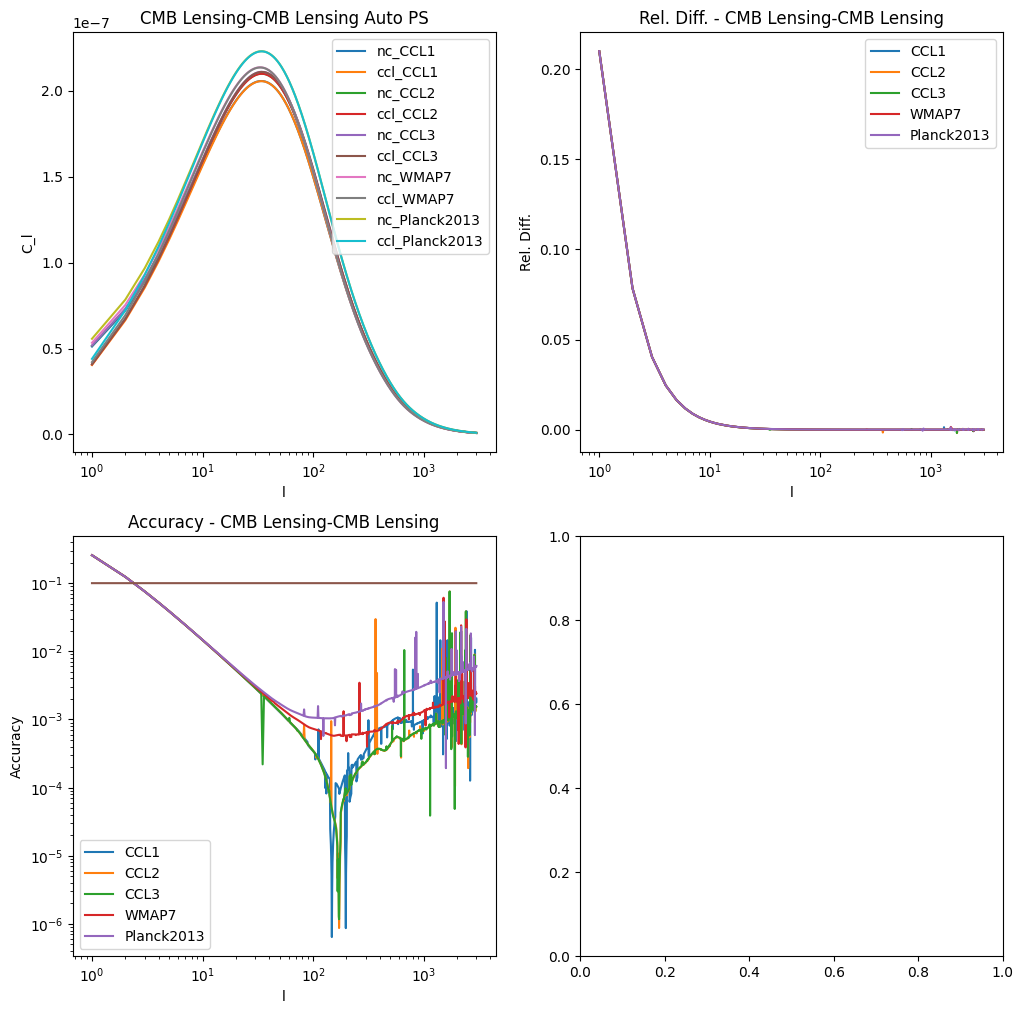

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

i=0
for cosmology in names:
    Omega_c = CCL_cosmologies[cosmology][0]
    Omega_b = CCL_cosmologies[cosmology][1]
    Omega_v = CCL_cosmologies[cosmology][2]
    h = CCL_cosmologies[cosmology][3]
    sigma8 = CCL_cosmologies[cosmology][4]
    n_s = CCL_cosmologies[cosmology][5]
    w0 = CCL_cosmologies[cosmology][6]
    wa = CCL_cosmologies[cosmology][7]
    Neff = CCL_cosmologies[cosmology][8]
    m_nu = CCL_cosmologies[cosmology][9]
        
    name=cosmology
    
    ccl_cl_cmblens_auto1_np, nc_cl_cmblens_auto1_np, relative_diff_cmblens_auto1, A_acc_cmblens_auto1 = \
    compare_CMBlens_CMBlens_angular_cl(Omega_c, Omega_b, Omega_v, h, sigma8, n_s, w0, wa, Neff, m_nu, z_lss, ells)

    label_auto1_nc = 'nc_'+name
    label_auto1_ccl = 'ccl_'+name
    label_auto1_rel_diff = name
    label_auto1_A_acc = name
     
    axs[0,0].plot(ells[1:], nc_cl_cmblens_auto1_np[1:], label=label_auto1_nc)
    axs[0,0].plot(ells[1:], ccl_cl_cmblens_auto1_np[1:], label=label_auto1_ccl) 

    axs[0,1].plot(ells[1:], relative_diff_cmblens_auto1[1:], label=label_auto1_rel_diff)

    axs[1,0].plot(ells[1:], A_acc_cmblens_auto1[1:], label=label_auto1_A_acc)

    if A_acc_cmblens_auto1.max()>0.1:
        print("A_acc_cmblens_auto1 max "+name+" = "+ str(A_acc_cmblens_auto1[A_acc_cmblens_auto1>0.1])+"\n")
        print("A_acc_cmblens_auto1 max value position "+name+" = "+ str(np.where(A_acc_cmblens_auto1>0.1)[0])+"\n")
    
    i+=1
    
axs[0, 0].set_title('CMB Lensing-CMB Lensing Auto PS')
axs[0, 0].legend(loc='upper right')
axs[0, 0].set(xlabel='l', ylabel='C_l')
axs[0, 0].set(xscale='log')

axs[0, 1].set_title('Rel. Diff. - CMB Lensing-CMB Lensing')
axs[0, 1].legend()
axs[0, 1].set(xlabel='l', ylabel='Rel. Diff.')
axs[0, 1].set(xscale='log')

expected_acc = np.empty(len(ells))
expected_acc.fill(0.1)
axs[1, 0].plot(ells[1:], expected_acc[1:])
axs[1, 0].set_title('Accuracy - CMB Lensing-CMB Lensing')
axs[1, 0].legend()
axs[1, 0].set(xlabel='l', ylabel='Accuracy')
axs[1, 0].set(xscale='log')
axs[1, 0].set(yscale='log')